In [1]:
from general import *

In [2]:
class PositionNeuron():
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk', 'I'])

    def __init__(self, parameters):
        super(PositionNeuron, self).__init__()
        self.tau = parameters['tau']
        self.V_R = parameters['V_R']
        self.V_T = parameters['V_T']
        self.w = parameters['w']
        self.n = parameters['n']
        self.N_input = parameters['N_input']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.full((self.n,), self.V_R),
                                          w=np.array(self.w),
                                          spk=np.zeros(self.n),
                                          I=np.zeros((self.n, self.N_input)))
        V = self.state.V
        w = self.state.w
        I = self.state.I

        V += self.dt*(self.V_R-V)/self.tau
        V += np.sum(w * input, axis=1)

        spk = np.heaviside(V - self.V_T, 0)
        V = (1 - spk) * V + spk * self.V_R 

        self.state = self.NeuronState(V=V, w=w, spk=spk, I=I)

        return V, spk

In [3]:
with open('data/spike_sensory', 'rb') as file:
    spike_sensory = np.load(file) 
    
with open('data/joint_angles_' + parameters['joint_string'], 'rb') as file:
    joint_angles = pickle.load(file)

time = np.linspace(0, constants['T_TOTAL'], num=constants['N_STEPS'])

position_parameters_uni = {'tau': 120e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': constants['N_ANGLES'], 'w': 1e-3,
                           'N_input': parameters['N_HAIRS'], 'dt': constants['dt'], 'refrac': 0}

position_parameters_bi = {'tau': 120e-3, 'V_T': -50e-3, 'V_R': -70e-3, 'n': 2 * constants['N_ANGLES'], 'w': 1e-3,
                           'N_input': parameters['N_HAIRS'] // 2, 'dt': constants['dt'], 'refrac': 0}

position_neuron_uni = PositionNeuron(position_parameters_uni)
position_neuron_uni.initialize_state()
position_neuron_bi = PositionNeuron(position_parameters_bi)
position_neuron_bi.initialize_state()

spike_position_uni = np.empty((constants['N_STEPS'], position_parameters_uni['n'], parameters['N_SIMULATIONS']), dtype=np.uint8)
spike_position_bi = np.empty((constants['N_STEPS'], position_parameters_bi['n'], parameters['N_SIMULATIONS']), dtype=np.uint8)

In [4]:
for k in tqdm(range(parameters['N_SIMULATIONS'])):    
    for i in range(constants['N_STEPS']):    
        reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters_bi['n'], (parameters['N_HAIRS'])))
        
        _, spike_position_uni[i, :, k] = position_neuron_uni.forward(reshaped_spikes[:18, :])
        _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
        
with open('data/spike_position', 'wb') as file:
        np.save(file, spike_position_bi)

  0%|          | 0/2 [00:00<?, ?it/s]

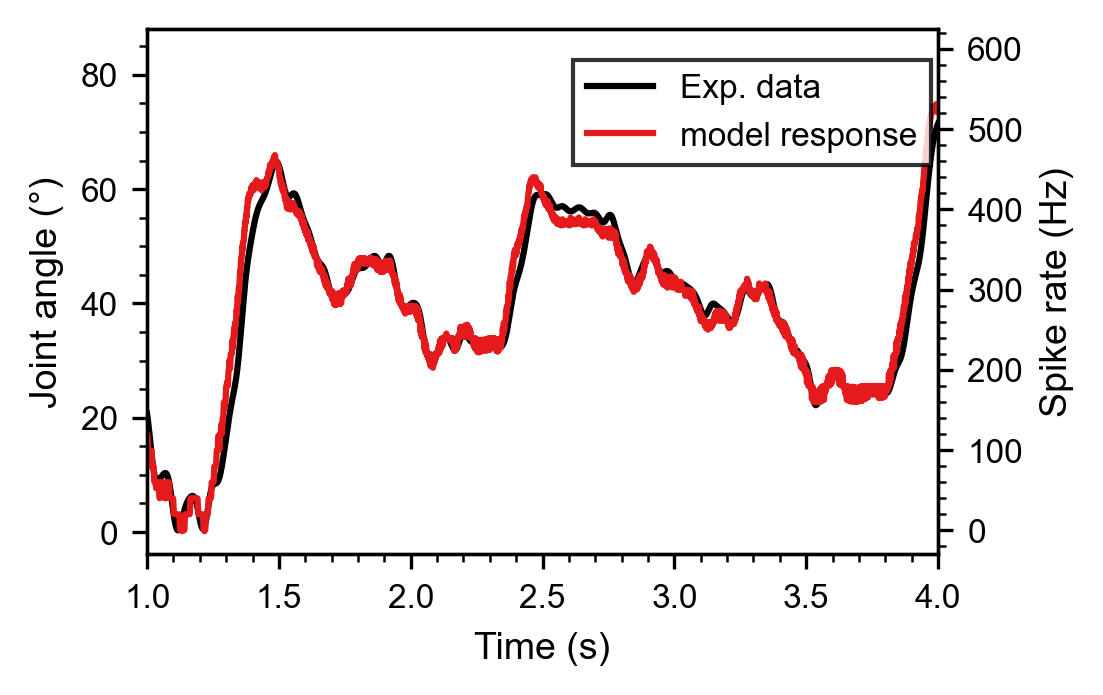

In [5]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

firing_rate = get_firing_rate_convolve(spike_position_uni[:, 1, 0], constants['dt'], 0.05)

ax2.plot(time, firing_rate, color=custom_colors[0], linestyle=custom_linestyles[0], label='model response')

ax1.plot(time, joint_angles[:, 0, 0], color='black', label='Exp. data')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (°)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([1, 4])
ax2.set_xlim([1, 4])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.75])

ax2.set_ylabel("Spike rate (Hz)")

fig.tight_layout(pad=parameters['pad'])
fig.savefig('Images/position_neuron/uni_position_din_.png')
fig.savefig('Images/position_neuron/uni_position_din_.pdf')

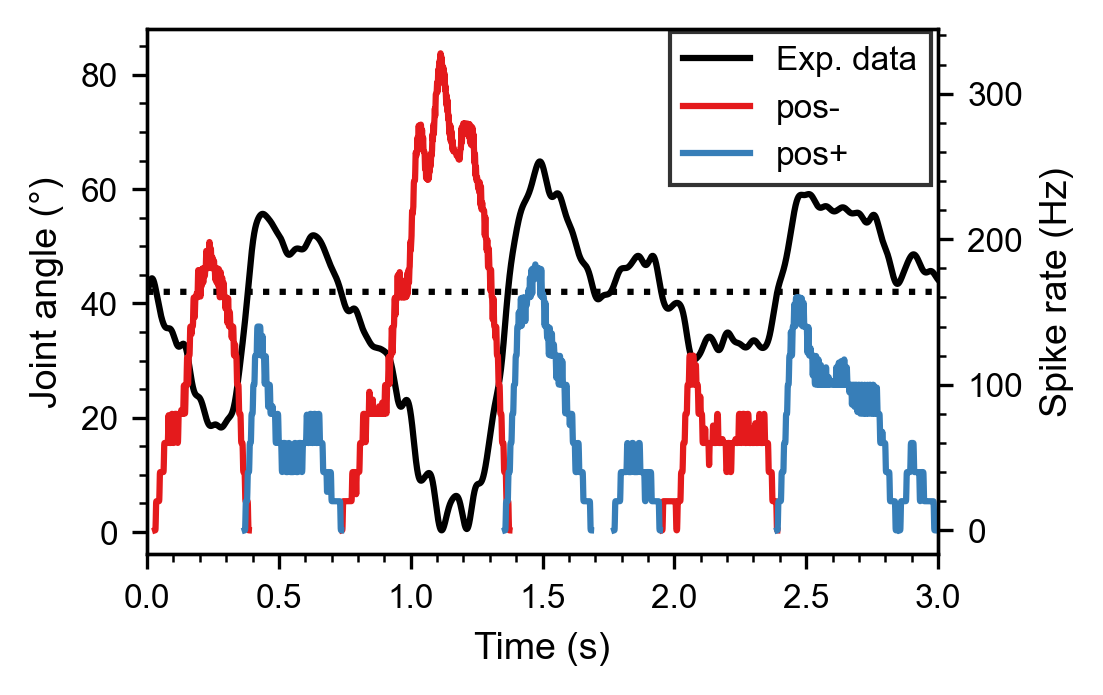

In [6]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

handles = ['pos-', 'pos+']

for i in range(2):
    firing_rate = get_firing_rate_convolve(spike_position_bi[:, i, 0], constants['dt'], 0.05)
    ax2.plot(time, firing_rate, color=custom_colors[i], label = handles[i])


ax1.plot(time, joint_angles[:, 0, 0], color='black', label='Exp. data')
ax1.plot(time, np.full(len(time), np.max(joint_angles[:, 0, 0]) / 2 + np.min(joint_angles[:, 0, 0]) / 2), linestyle='dotted',
         color='black')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Joint angle (°)")
ax1.minorticks_on()
ax2.minorticks_on()

ax1.set_xlim([0, 3])
ax2.set_xlim([0, 3])
fig.legend(loc='lower right', fancybox=False, edgecolor='black', bbox_to_anchor=[0.87, 0.72])

ax2.set_ylabel("Spike rate (Hz)")

fig.tight_layout(pad=parameters['pad'])
fig.savefig('Images/position_neuron/bi_position_din_.png')
fig.savefig('Images/position_neuron/bi_position_din_.pdf')

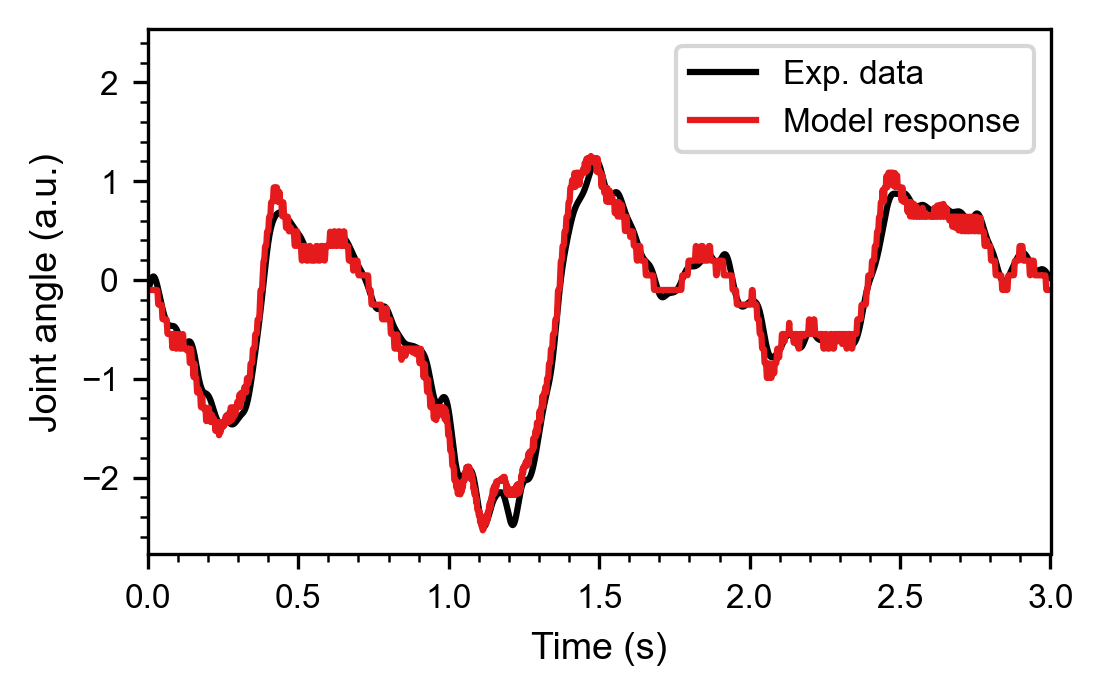

In [7]:
firing_rate_down = get_firing_rate_convolve(spike_position_bi[:, 0, 0], constants['dt'], 0.05, nan_bool=False)
firing_rate_up = get_firing_rate_convolve(spike_position_bi[:, 1, 0], constants['dt'], 0.05, nan_bool=False)

combined_firing_rate = firing_rate_up - firing_rate_down

combined_firing_rate_norm = zscore.zscore(combined_firing_rate)
joint_angle_norm = zscore.zscore(joint_angles[:, 0, 0])

fig, ax = plt.subplots()

ax.plot(time, joint_angle_norm, color='black', label='Exp. data')
ax.plot(time, combined_firing_rate_norm, color=custom_colors[0], label = 'Model response')

ax.set_xlim([0, 3])
ax.set_xlabel("Time (s)")
ax.set_ylabel("Joint angle (a.u.)")
ax.minorticks_on()
ax.legend()

fig.tight_layout(pad=parameters['pad'])
fig.savefig('Images/position_neuron/combined_position_din_.png')
fig.savefig('Images/position_neuron/combined_position_din_.pdf')

In [8]:
N_GRID = 8
N_ANGLES = 18
weight_list = np.linspace(1e-3, 8e-3, num=N_GRID)
tau_list = np.linspace(40e-3, 180e-3, num=N_GRID)
MSE =  np.empty((N_ANGLES, parameters['N_SIMULATIONS'], N_GRID, N_GRID))
euclidean_norm = lambda x, y: np.abs(x - y)

for l, m in tqdm(np.ndindex(N_GRID, N_GRID), desc=f'Total {N_GRID*N_GRID}'): 
    position_parameters_bi['w'] = weight_list[l]
    position_parameters_bi['tau'] = tau_list[m]
    
    position_neuron_bi = PositionNeuron(position_parameters_bi)
    position_neuron_bi.initialize_state()
    
    for k in range(parameters['N_SIMULATIONS']):  
        for i in range(constants['N_STEPS']):       
           reshaped_spikes = np.reshape(spike_sensory[i, :, k], (position_parameters_bi['n'], (parameters['N_HAIRS'])))
        
           _, spike_position_bi[i, :, k] = position_neuron_bi.forward(reshaped_spikes[:, parameters['N_HAIRS'] // 2:])
        
        for i in range(N_ANGLES):
        
            firing_rate_down = get_firing_rate_convolve(spike_position_bi[:, 0 + 2*i, k], constants['dt'], 0.05, nan_bool=False)
            firing_rate_up = get_firing_rate_convolve(spike_position_bi[:, 1 + 2*i, k], constants['dt'], 0.05, nan_bool=False)
            
            
            combined_firing_rate = firing_rate_up - firing_rate_down
                      
            combined_firing_rate = zscore.zscore(combined_firing_rate)

            joint_angle = zscore.zscore(joint_angles[:, i, k])
                      
            MSE[i, k, l, m] = np.mean((combined_firing_rate - joint_angle)**2)

Total 64: 0it [00:00, ?it/s]

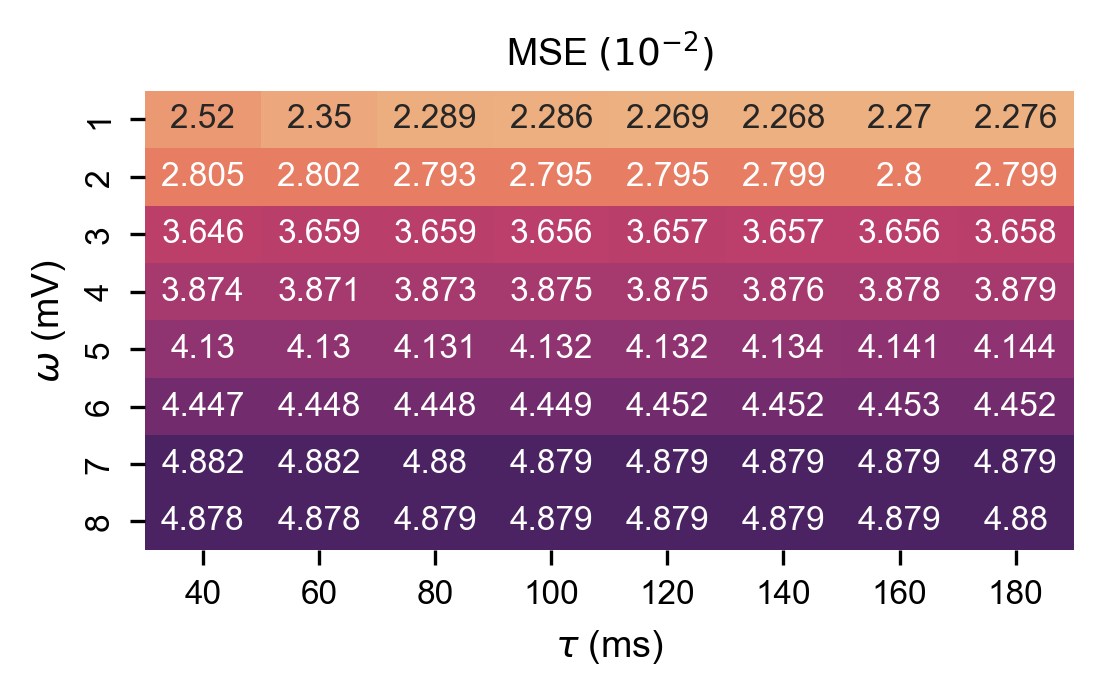

In [9]:
import seaborn as sns

MSE = np.mean(MSE*100, axis=(0, 1))

df = pd.DataFrame(MSE, index=np.round(weight_list*1E3).astype(int), columns=np.round(tau_list*1E3).astype(int))
fig, ax = plt.subplots()
heatmap = sns.heatmap(data=df, annot=True, fmt='.4g', cbar_kws={'label': 'MSE $(10^{-2})$'}, cbar=False, cmap='flare', annot_kws={"fontsize":8})
heatmap.set(ylabel='$\omega$ (mV)', xlabel=r'$\tau$ (ms)')

ax.set_title('MSE $(10^{-2})$')

fig.tight_layout(pad=parameters['pad'])
fig.savefig('Images/position_neuron/position_heatmap.png')
fig.savefig('Images/position_neuron/position_heatmap.pdf')